# Setup and Imports

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random

# Configure plots
plt.style.use("ggplot")
sns.set(font_scale=1.1)

# For reproducibility
np.random.seed(42)
random.seed(42)

# Define Constants and Assets Universe

In [42]:
import yfinance as yf

# Sample set of real-world tickers (you can expand this later)
real_tickers = [
    # ETFs
    "SPY", "QQQ", "IVV", "VOO", "ARKK", "XLK", "SCHX", "DIA",
    "IWM", "TLT", "BND", "EFA", "EEM", "XLF", "XLE", "XLV", "VNQ", "IEMG",
    
    # Mutual Funds
    "FXAIX", "VFIAX", "VTSAX", "SWPPX", "VIGAX", "VIGRX", "SWTSX", "FZROX",
    
    # Large Equities
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "BRK-B", "META", "UNH", "JNJ",
    "V", "PG", "XOM", "MA", "HD", "PFE", "CVX", "KO", "PEP", "LLY",
    
    # Mid-cap/other
    "COST", "AVGO", "ADBE", "CSCO", "TMO", "CRM", "MRK", "INTC", "BAC", "WMT",
    "ORCL", "ABBV", "ABT", "TXN", "MCD", "NKE", "QCOM", "MDT", "HON", "NEE",
    "UPS", "T", "AMAT", "SBUX", "GE", "LOW", "CAT", "RTX", "DE", "GS"
]

PROVIDERS = ["BlackRock", "Vanguard", "Charles Schwab"]

metadata = []
for ticker in real_tickers:
    try:
        t = yf.Ticker(ticker)
        info = t.info
        metadata.append({
            "ticker_id": ticker,
            "asset_name": info.get("shortName", "Unknown"),
            "asset_type": info.get("quoteType", "Unknown"),
        })
    except Exception as e:
        print(f"Skipping {ticker}: {e}")

# Filter down to clean entries and create DataFrame
base_assets = pd.DataFrame(metadata).dropna().drop_duplicates("ticker_id").reset_index(drop=True)

# Randomly assign each ticker to 1–3 providers
rows = []
for _, row in base_assets.iterrows():
    assigned_providers = random.sample(PROVIDERS, random.randint(1, 3))
    for provider in assigned_providers:
        rows.append({
            "ticker_id": row["ticker_id"],
            "asset_name": row["asset_name"],
            "asset_type": row["asset_type"],
            "provider": provider
        })

# Final asset universe DataFrame
asset_universe = pd.DataFrame(rows).reset_index(drop=True)
print(asset_universe.shape)
asset_universe.head(10)


(145, 4)


,ticker_id,asset_name,asset_type,provider
0,SPY,SPDR S&P 500,ETF,BlackRock
1,SPY,SPDR S&P 500,ETF,Charles Schwab
2,SPY,SPDR S&P 500,ETF,Vanguard
3,QQQ,"Invesco QQQ Trust, Series 1",ETF,BlackRock
4,IVV,iShares Core S&P 500 ETF,ETF,Charles Schwab
5,VOO,Vanguard S&P 500 ETF,ETF,Charles Schwab
6,ARKK,ARK Innovation ETF,ETF,Charles Schwab
7,ARKK,ARK Innovation ETF,ETF,BlackRock
8,ARKK,ARK Innovation ETF,ETF,Vanguard
9,XLK,SPDR Select Sector Fund - Techn,ETF,BlackRock


# Simulate Daily Flow Table

In [43]:
# Daily date range for 2024
date_range = pd.date_range(start="2024-01-01", end="2024-12-31", freq="D")

# Initialize time series rows
flow_rows = []

for _, row in asset_universe.iterrows():
    base_nav = np.random.uniform(20, 400)  # starting NAV
    base_aum = np.random.uniform(1_000_000_000, 20_000_000_000)  # simulate initial AUM per asset-provider

    for date in date_range:
        # Simulate inflow/outflow as percentage of AUM
        inflow = round(np.random.uniform(0, 0.02) * base_aum, 2)
        outflow = round(np.random.uniform(0, 0.02) * base_aum, 2)
        net_flow = round(inflow - outflow, 2)

        # NAV drift
        nav_change = np.random.normal(0, 0.003)  # small daily change
        base_nav *= (1 + nav_change)
        base_nav = round(base_nav, 2)

        flow_rows.append({
            "ticker_id": row["ticker_id"],
            "asset_name": row["asset_name"],
            "asset_type": row["asset_type"],
            "provider": row["provider"],
            "date": date,
            "inflow": inflow,
            "outflow": outflow,
            "net_flow": net_flow,
            "nav": base_nav
        })

# Create final daily flow table
daily_flow_table = pd.DataFrame(flow_rows)


In [44]:

daily_flow_table_path = "../data/daily_flow_table.csv"
daily_flow_table.to_csv(daily_flow_table_path, index=False)

daily_flow_table_path

'../data/daily_flow_table.csv'

# Pertubate To Generate External Tables

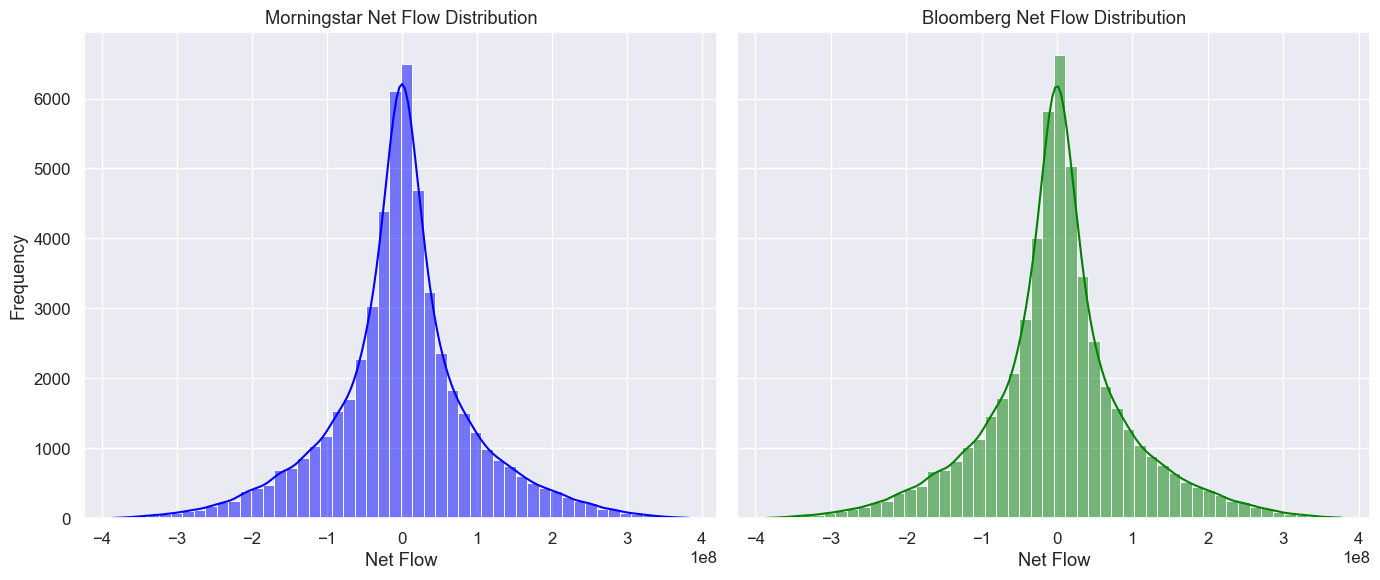

In [45]:
def perturb_flows_only(df, inflow_shape=2.0, inflow_scale=1_500_000, outflow_shape=2.5, outflow_scale=1_000_000, seed=None):
    modified = df.copy()

    if seed is not None:
        np.random.seed(seed)

    # Generate Gamma-distributed noise for inflow and outflow
    inflow_noise = np.random.gamma(shape=inflow_shape, scale=inflow_scale, size=len(modified))
    outflow_noise = np.random.gamma(shape=outflow_shape, scale=outflow_scale, size=len(modified))

    # Apply noise
    modified["inflow"] = (modified["inflow"] + inflow_noise).round(2)
    modified["outflow"] = (modified["outflow"] + outflow_noise).round(2)

    # Recalculate net flow
    modified["net_flow"] = (modified["inflow"] - modified["outflow"]).round(2)

    return modified

# Generate perturbed Morningstar and Bloomberg datasets
morningstar_df = perturb_flows_only(daily_flow_table, inflow_shape=2.0, inflow_scale=1_500_000, outflow_shape=2.5, outflow_scale=1_000_000, seed=1)
bloomberg_df = perturb_flows_only(daily_flow_table, inflow_shape=2.2, inflow_scale=1_600_000, outflow_shape=2.7, outflow_scale=1_100_000, seed=2)

# Save to CSV
morningstar_path = "../data/morningstar_flow_table_perturbed.csv"
bloomberg_path = "../data/bloomberg_flow_table_perturbed.csv"

morningstar_df.to_csv(morningstar_path, index=False)
bloomberg_df.to_csv(bloomberg_path, index=False)

morningstar_path, bloomberg_path

# Plot perturbation distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.histplot(morningstar_df["net_flow"], bins=50, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Morningstar Net Flow Distribution")
axes[0].set_xlabel("Net Flow")
axes[0].set_ylabel("Frequency")

sns.histplot(bloomberg_df["net_flow"], bins=50, kde=True, ax=axes[1], color="green")
axes[1].set_title("Bloomberg Net Flow Distribution")
axes[1].set_xlabel("Net Flow")

plt.tight_layout()
plt.show()

# Generate Aggregate Table

In [46]:
# Step 1: Aggregate net flow by month, ticker_id, provider
monthly_net_flow = daily_flow_table.copy()
monthly_net_flow["month"] = monthly_net_flow["date"].dt.to_period("M").dt.to_timestamp()
monthly_net_flow = monthly_net_flow.groupby(["ticker_id", "provider", "month"])["net_flow"].sum().reset_index()

# Step 2: Add one month prior (e.g. Dec 2023) with random starting value
first_month = monthly_net_flow["month"].min()
starting_month = (first_month - pd.DateOffset(months=1)).replace(day=1)

# Create initial starting value per asset
starting_rows = []
for (ticker, provider), group in monthly_net_flow.groupby(["ticker_id", "provider"]):
    starting_assets = round(np.random.uniform(100_000_000, 2_000_000_000), 2)
    starting_rows.append({
        "ticker_id": ticker,
        "provider": provider,
        "month": starting_month,
        "net_flow": 0.0,
        "total_assets": starting_assets
    })

# Create DataFrame for starting month
starting_df = pd.DataFrame(starting_rows)

# Step 3: Combine and compute running total
combined = pd.concat([starting_df, monthly_net_flow], ignore_index=True)
combined = combined.sort_values(by=["ticker_id", "provider", "month"])

# Step 4: Compute total_assets as cumulative sum of net_flow starting from initial
combined["total_assets"] = combined.groupby(["ticker_id", "provider"])["net_flow"].cumsum() + \
                           combined.groupby(["ticker_id", "provider"])["total_assets"].ffill()

# Fill any remaining total_assets
combined["total_assets"] = combined.groupby(["ticker_id", "provider"])["total_assets"].ffill().round(2)

# Final monthly AUM table
monthly_aum_table = combined[["ticker_id", "provider", "month", "net_flow", "total_assets"]].copy()
monthly_aum_table.head()


,ticker_id,provider,month,net_flow,total_assets
0,AAPL,BlackRock,2023-12-01,0.000000e+00,1.624022e+09
145,AAPL,BlackRock,2024-01-01,6.591141e+08,2.283136e+09
146,AAPL,BlackRock,2024-02-01,6.637994e+08,2.946936e+09
147,AAPL,BlackRock,2024-03-01,1.023141e+09,3.970077e+09
148,AAPL,BlackRock,2024-04-01,1.047442e+09,5.017519e+09


In [47]:
# Save the monthly AUM table to CSV
monthly_aum_path = "../data/monthly_aum_table.csv"
monthly_aum_table.to_csv(monthly_aum_path, index=False)

monthly_aum_path


'../data/monthly_aum_table.csv'